# Text Analysis with SQL Server Machine Learning Services, revoscalepy and microsoftml

### The goal: visualize and analyze text data without it leaving the SQL Server machine! 

When a customer sends a support ticket, it is important to route it to the right team. In this notebook, we train a model to predict which team a support ticket belongs to based on the subject and text of the ticket. 

With SQL Server ML Services, we can visualize the data and train the model on the SQL Server machine, without the data ever having to leave!

## Setup our SQL Server compute context and visualize a small sample of the data

This "compute context" will allow us to easily execute arbitrary Python functions on our SQL Server machine.

In [1]:
from revoscalepy import RxInSqlServer, rx_exec, RxSqlServerData, rx_import
import os

db = "TextClassification_Py"

connection_string = "Driver=SQL Server;Server={};Database={};Trusted_Connection=Yes;".format("localhost", db)

sql_compute_context = RxInSqlServer(connection_string=connection_string)

sql_sample = RxSqlServerData(sql_query="select top 5 * from News_Train", connection_string=connection_string)
df_sample = rx_import(sql_sample)
df_sample.head()

Rows Read: 5, Total Rows Processed: 5, Total Chunk Time: 0.003 seconds 


,Label,Subject,Text,Id
0,7,WHAT car is this!?,I was wondering if anyone out there could enli...,1
1,4,SI Clock Poll - Final Call,A fair number of brave souls who upgraded thei...,2
2,4,PB questions...,"""well folks, my mac plus finally gave up the g...",3
3,1,Re: Weitek P9000 ?,"""X-Newsreader: TIN [version 1.1 PL9] Robert J....",4
4,5,"german keyboard, X11R5 and Sparc",I have a Sparc[12] with a german type 4 keyboa...,1710


## Visualize the data

### Visualization with a histogram of string lengths for the Subject column

We use the `rx_exec` function below to execute `generate_histogram` on our SQL Server machine. This processes the data "In-DB", generates a histogram, and returns the histogram image to the client. Of course, the data never leaves the machine :)

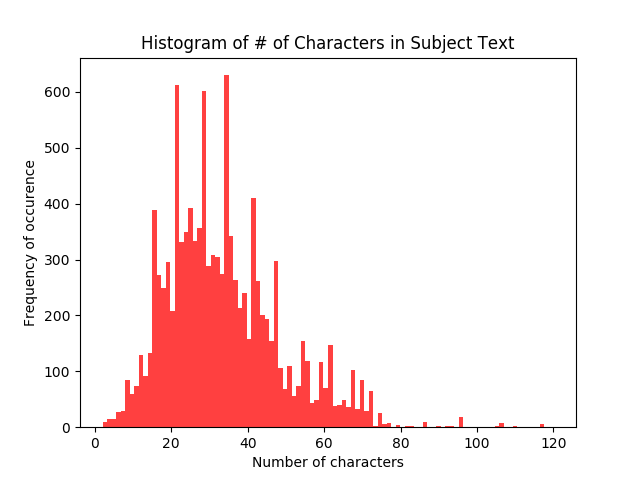

In [3]:
from IPython import display

def generate_histogram():
    from revoscalepy import RxSqlServerData, rx_import
    import matplotlib.pyplot as plt
    import io
    
    internal_con_str = "Driver=SQL Server;Server=localhost;Database=TextClassification_Py;Trusted_Connection=Yes;"
    sql_train_data = RxSqlServerData(connection_string=internal_con_str, sql_query = "select * from News_Train")
    df = rx_import(sql_train_data)
    
    plt.hist(df["Subject"].str.len(), 100, facecolor='red', alpha=0.75)
    plt.title('Histogram of # of Characters in Subject Text')
    plt.xlabel('Number of characters')
    plt.ylabel('Frequency of occurence')
    
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    
    return buf.getvalue()

histogram = rx_exec(generate_histogram, compute_context=sql_compute_context)[0]
display.Image(data=histogram)

## Define the featurization for the training set

We can train a more accurate model if we extract the most important information from the raw string data. 

In this step, we use the featurize_text function from the microsoftml module to define a transformation. We do not actually perform the transformation.

The transformation we define removes nonessential information from the input data, such as numbers and diacritics. It also hashes different words in the data for processing. 

This process is often referred to as "featurizing" the data. We are trying to extract the "features" of the data we want to train our model based on.

In [4]:
from microsoftml import featurize_text
from microsoftml.entrypoints._stopwordsremover_predefined import predefined
from microsoftml import featurize_text, n_gram_hash

# Define the transformation to be used to generate features. 
# It will be applied on the fly during training and testing.
# Here, for each the text and subject of the data, we: 
# - Remove stopwords, diacritics, punctuation and numbers.
# - Change capital letters to lower case. 
# - Hash the different words and characters. 
# The parameters or options can be further optimized by parameter sweeping.
# Other languages can be used.
text_transform_list = [featurize_text(cols = dict(SubjectPreprocessed = "Subject", TextPreprocessed = "Text"), 
                                     language = "English",
                                     stopwords_remover = predefined(),
                                     case = "Lower",
                                     keep_diacritics  = False,                                                   
                                     keep_punctuations = False,
                                     keep_numbers = False,
                                     word_feature_extractor = n_gram_hash(hash_bits = 17, ngram_length = 2, seed = 4),
                                     char_feature_extractor = n_gram_hash(hash_bits = 17, ngram_length = 3, seed = 4),
                                     vector_normalizer = "L2")]

## Train the model

Now that we have the feature transformation setup, we can actually train the model. 

In this code, we first get a list of the distinct labels in the training set. We feed the information to our model so it knows how many classes of data it is dealing with.

We then setup our training formula ("Label ~ SubjectPreprocessed + TextPreprocessed"). This formula states, train a model that predicts Label based on the SubjectPreprocessed and TextPreprocessed columns. (These columns are the outputs of our transformation defined above). 

## In-Database Model Training

You may notice the compute_context parameter we pass into the call to rx_logistic_regression. The argument we pass indicates that the model should be trained "In-DB". Thus, the computation is "shipped" to the SQL Server machine. All of the model training happens on the SQL Server, and the data never has to leave the machine!

In [5]:
from revoscalepy import rx_set_compute_context, RxInSqlServer, RxLocalSeq, RxOdbcData, rx_write_object, RxSqlServerData, rx_import
from microsoftml import rx_logistic_regression, rx_predict

# Write the distinct label values into an information dict for logistic model
sql_distinct_labels = RxSqlServerData(sql_query = "SELECT DISTINCT Label FROM News_Train",
                              connection_string = connection_string)
levels_list  = list(rx_import(sql_distinct_labels)['Label'])
factor_info = {'Label':{'type' : 'factor', 'levels' : [str(s) for s in levels_list]}}

sql_news_train = RxSqlServerData(connection_string=connection_string, sql_query = "select * from News_Train", 
                                 column_info=factor_info)

# Train the multiclass logistic regression model on the SQL Server.
training_formula = "Label ~ SubjectPreprocessed + TextPreprocessed"
logistic_model = rx_logistic_regression(formula = training_formula,
                                        data = sql_news_train,
                                        method = "multiClass",
                                        l2_weight = 1, 
                                        l1_weight = 1,
                                        ml_transforms = text_transform_list,
                                        train_threads = 4,
                                        compute_context = sql_compute_context)

# Save serialized model to SQL Server
models_odbc = RxOdbcData(connection_string, table = "Model")
rx_write_object(models_odbc, key = "LR", value = logistic_model, serialize = True, overwrite = True)

Rows Read: 20, Total Rows Processed: 20, Total Chunk Time: 0.009 seconds 
Elapsed time: 00:00:07.5615101
Rows Read: 1, Total Rows Processed: 1
Total Rows written: 1, Total time: 0.002
, Total Chunk Time: 0.031 seconds 


True

## Score the model and show predictions

Now that we have a model trained, we want to see how it performs on some test data.

In this code, we use rx_predict to predict with our model on test data stored in the News_Test table. We use the output_data argument to rx_predict to store the prediction in the Predictions_Intermediate table.

Note the compute_context argument to rx_predict. <b>The prediction all happens on the SQL Server machine!</b>

We then use a SQL join query to show a sample of what our model predicts versus the actual Label values. Note: below we do allow the Label and PredictedLabel data to leave the machine, but none of the actual Subject/Text information.

In [8]:
from revoscalepy import rx_data_step

# Logistic Regression Scoring

# Point to the testing set. 
sql_news_test = RxSqlServerData(table = "News_Test",
                                connection_string = connection_string,
                                column_info = factor_info)

# Make Predictions while featurizing the text variables separately on the fly.
# This will automatically use the same text transformation as in the training, encoded in logistic_model.
sql_predictions_intermediate = RxSqlServerData(table = "Predictions_Intermediate", connection_string = connection_string)

rx_predict(model = logistic_model,
           data = sql_news_test,
           output_data = sql_predictions_intermediate,
           extra_vars_to_write = ["Label", "Id"],
           overwrite = True, 
           compute_context=RxInSqlServer(connection_string=connection_string))

sql_predictions_join = RxSqlServerData(sql_query = "SELECT LabelNames, Predictions_Intermediate.* \
                                              FROM Predictions_Intermediate INNER JOIN Label_Names \
                                              ON Predictions_Intermediate.PredictedLabel = Label_Names.Label", 
                                connection_string = connection_string)

sql_predictions = RxSqlServerData(table = "Predictions", connection_string = connection_string, strings_as_factors = True)
rx_data_step(input_data = sql_predictions_join, output_file = sql_predictions, 
             overwrite = True, compute_context=sql_compute_context)

df_predictions = rx_import(sql_predictions)
df_predictions.head(10)

Rows Read: 7516, Total Rows Processed: 7516
Total Rows written: 7516, Total time: 0.298
, Total Chunk Time: 0.413 seconds 
Rows Read: 7516, Total Rows Processed: 7516, Total Chunk Time: 0.104 seconds 


,LabelNames,Label,Id,PredictedLabel,Score.0,Score.9,Score.15,Score.3,Score.12,Score.6,...,Score.4,Score.19,Score.13,Score.5,Score.16,Score.2,Score.17,Score.11,Score.14,Score.8
0,sci.med,7,11297,13,0.011209,0.054132,0.056636,0.108986,0.098353,0.028482,...,0.046197,0.017565,0.162684,0.044120,0.040696,0.042056,0.020379,0.012836,0.021277,0.057063
1,comp.windows.x,5,11298,5,0.002927,0.003998,0.003423,0.016868,0.011169,0.004267,...,0.050305,0.001542,0.003964,0.827637,0.002705,0.010069,0.000937,0.001809,0.010362,0.020061
2,alt.atheism,0,11299,0,0.441915,0.022303,0.182930,0.011085,0.014162,0.013692,...,0.013420,0.030580,0.022372,0.015386,0.017225,0.011914,0.037565,0.012849,0.043488,0.022150
3,talk.politics.guns,17,11300,16,0.028926,0.034075,0.043050,0.055384,0.079434,0.018273,...,0.058458,0.040254,0.042122,0.025343,0.109529,0.062458,0.056899,0.044264,0.040244,0.043794
4,talk.religion.misc,19,11301,19,0.311697,0.010290,0.011603,0.002738,0.002171,0.001060,...,0.003034,0.568403,0.007547,0.001965,0.007721,0.002333,0.016253,0.004367,0.006983,0.006872
5,sci.med,13,11302,13,0.089098,0.017766,0.023114,0.035898,0.041767,0.004620,...,0.026756,0.075043,0.306791,0.012335,0.053451,0.026822,0.027991,0.024421,0.032943,0.047611
6,soc.religion.christian,15,11303,15,0.008581,0.119825,0.431208,0.018893,0.024733,0.042164,...,0.026059,0.011797,0.040873,0.026748,0.021291,0.013911,0.022841,0.014387,0.028636,0.021137
7,sci.electronics,15,11304,12,0.003824,0.016691,0.015733,0.061560,0.192203,0.090254,...,0.046407,0.006577,0.046465,0.075024,0.011011,0.174176,0.010931,0.027593,0.012455,0.024129
8,comp.windows.x,5,11305,5,0.009542,0.011441,0.024273,0.015514,0.048092,0.034631,...,0.017437,0.012084,0.083689,0.468702,0.023569,0.012717,0.054109,0.025635,0.049023,0.005167
9,talk.politics.misc,18,12218,18,0.070572,0.016208,0.012888,0.010023,0.010304,0.004533,...,0.023868,0.027048,0.060303,0.005879,0.058122,0.008005,0.059824,0.019602,0.026010,0.040327


## Model accuracy on test data

Below we show confusion matrix calculated from our predictions on the test data, versus the actual values.

In [9]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model.
conf_matrix = confusion_matrix(y_true = df_predictions["Label"], y_pred = df_predictions["PredictedLabel"])

# Compute Evaluation Metrics. 
## Micro Average accuracy: 
micro = sum(conf_matrix[i][i] for i in range(conf_matrix.shape[0]))/df_predictions.shape[0]
print("Micro Average Accuracy is {}".format(micro))

## Macro Average accuracy:
macro = sum(conf_matrix[i][i]/(sum(conf_matrix[i][j] for j in range(conf_matrix.shape[0]))) for i in range(conf_matrix.shape[0]))/conf_matrix.shape[0]
print("Macro Average Accuracy is {}".format(macro))

## Per-class precision, recall and F1-score. 
results = classification_report(y_true = df_predictions["Label"], y_pred = df_predictions["PredictedLabel"])
print(results)

Micro Average Accuracy is 0.6808142629058009
Macro Average Accuracy is 0.675383168896462
             precision    recall  f1-score   support

          0       0.74      0.56      0.64       318
          1       0.59      0.60      0.59       389
         10       0.75      0.75      0.75       399
         11       0.93      0.80      0.86       396
         12       0.52      0.55      0.53       393
         13       0.59      0.62      0.60       394
         14       0.85      0.77      0.81       393
         15       0.73      0.74      0.73       398
         16       0.65      0.65      0.65       364
         17       0.80      0.76      0.78       376
         18       0.55      0.55      0.55       310
         19       0.60      0.52      0.56       251
          2       0.69      0.65      0.67       391
          3       0.53      0.64      0.58       392
          4       0.73      0.65      0.69       383
          5       0.75      0.74      0.75       394
         